# Recommender Systems with Surprise
- **Created by Andrés Segura Tinoco**
- **Created on May 27, 2019**

## Experiment description
- Model built from a Pandas dataframe
- The algorithm used is: Singular Value Decomposition (SVD)
- Model trained using train and test datasets (80/20) and cross-validation
- The RMSE and MAE metrics were used to estimate the model error
- Type of filtering: collaborative

In [1]:
# Load the Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Load Surprise libraries
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV

In [3]:
# Load plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Path to dataset file
file_path = os.path.expanduser('../data/u.data')

# Read current ratings of the users
rawdata = pd.read_csv(file_path, sep = '\t', names = ['user_id','item_id','rating','timestamp'])
rawdata.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## 1. Manual Tune

In [5]:
# Split data in training and test
train_data, test_data = train_test_split(rawdata, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (80000, 4)
Test size: (20000, 4)


In [6]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['user_id', 'item_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['user_id', 'item_id', 'rating']], reader)

In [7]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [8]:
# Plot the model RMSE
def plot_model_rmse(xs, ys, title, x_label, y_label):
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(xs, ys, marker = 'o')
    
    for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title(title, fontsize = 12)
    plt.xlabel(x_label, fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)
    plt.draw()

**Number of factors (k)**

In [9]:
# Factors list
k_factors = [5, 10, 25, 50, 75, 100]

In [10]:
# Results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for k in k_factors:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=0, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [11]:
# Train RMSE dataframe
error_data = {'k': k_factors, 'error': train_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.749114
1,10,0.648052
2,25,0.424839
3,50,0.204755
4,75,0.095559
5,100,0.049433


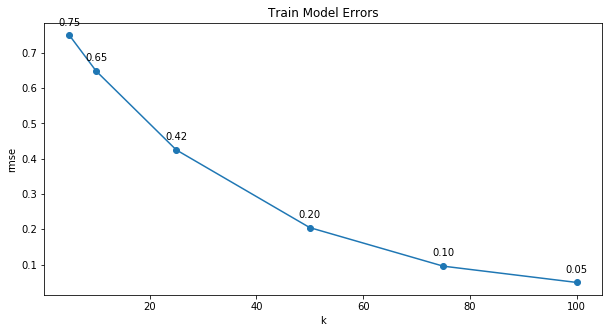

In [12]:
# Set up the matplotlib figure
plot_model_rmse(error_data['k'], error_data['error'], 'Train Model Errors', 'k', 'rmse')

In [13]:
# Test RMSE dataframe
error_data = {'k': k_factors, 'error': test_rmse}
pd.DataFrame(error_data)

,k,error
0,5,0.959152
1,10,1.020392
2,25,1.124666
3,50,1.136032
4,75,1.092518
5,100,1.055903


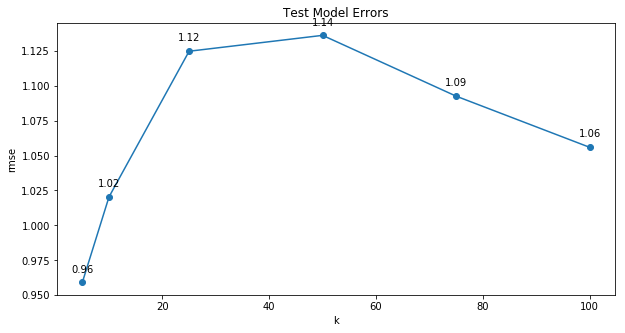

In [14]:
# Set up the matplotlib figure
plot_model_rmse(error_data['k'], error_data['error'], 'Test Model Errors', 'k', 'rmse')

**The regularization term for all parameters. Default is 0.02**

In [15]:
# Lista de valores de regularización
k = 5
reg_all = [0.01, 0.02, 0.1, 0.5, 1]

In [16]:
# Results
train_rmse = []
test_rmse = []

# Loop in which errors are calculated
for reg in reg_all:
    algo = SVD(n_factors=k, n_epochs=200, biased=True, lr_all=0.005, reg_all=reg, init_mean=0, init_std_dev=0.01, verbose=False)
    algo.fit(data_train)
    
    # The error of the training data is calculated and saved
    predictions = algo.test(data_trainset)
    error = accuracy.rmse(predictions, verbose = False)
    train_rmse.append(error)
    
    # The error of the testing data is calculated and saved
    predictions_test = algo.test(data_testset)
    error = accuracy.rmse(predictions_test, verbose = False)
    test_rmse.append(error)

In [17]:
# Train RMSE dataframe
error_data = {'reg_all': reg_all, 'error': train_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.751460
1,0.02,0.753578
2,0.10,0.804762
3,0.50,0.938582
4,1.00,0.969529


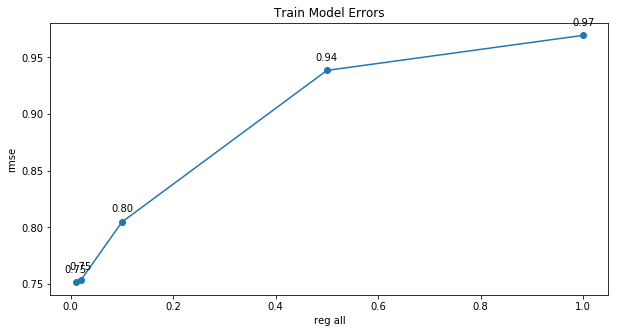

In [18]:
# Set up the matplotlib figure
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

In [19]:
# Test RMSE dataframe
error_data = {'reg_all': reg_all, 'error': test_rmse}
pd.DataFrame(error_data)

,reg_all,error
0,0.01,0.950153
1,0.02,0.942324
2,0.10,0.912727
3,0.50,0.955983
4,1.00,0.980417


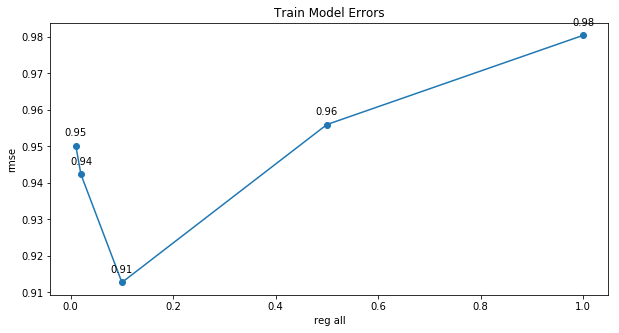

In [20]:
# Set up the matplotlib figure
plot_model_rmse(error_data['reg_all'], error_data['error'], 'Train Model Errors', 'reg all', 'rmse')

## 2. Auto Tune

The **GridSearchCV** class computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. This is useful for finding the best set of parameters for a prediction algorithm.

In [21]:
# Read the raw data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
dataset = Dataset.load_from_df(rawdata[['user_id', 'item_id', 'rating']], reader)

In [22]:
# SVD params
param_grid = {'n_factors': [5, 10, 20],
              'n_epochs': [10, 20, 30],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

In [23]:
# Tune algorithm parameters with GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv = 3)
gs.fit(dataset)

In [24]:
# Best RMSE and MAE scores
print(gs.best_score)

{'rmse': 0.9569991603829203, 'mae': 0.7662618189358344}


In [25]:
# Combination of parameters that gave the best scores
print(gs.best_params)

{'rmse': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}, 'mae': {'n_factors': 5, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}}


In [26]:
# The cv_results attribute has all the needed information 
gs.cv_results

{'split0_test_rmse': array([0.97637567, 0.98424261, 0.96246437, 0.97178563, 0.96465281,
        0.97367336, 0.95721583, 0.96707804, 0.96023222, 0.96970146,
        0.95563866, 0.96565109, 0.97648165, 0.98433108, 0.96247011,
        0.97183021, 0.9646167 , 0.9736898 , 0.95722209, 0.96708281,
        0.96025641, 0.96971158, 0.95565116, 0.96565334, 0.97653973,
        0.98437376, 0.96248025, 0.97181384, 0.96467814, 0.97368375,
        0.95724905, 0.96708195, 0.96028452, 0.96971715, 0.95564067,
        0.9656594 ]),
 'split1_test_rmse': array([0.97688354, 0.9855507 , 0.96278516, 0.97296212, 0.96502154,
        0.97492966, 0.95764016, 0.96826719, 0.96070995, 0.97098255,
        0.95610797, 0.96686023, 0.97695555, 0.9855921 , 0.96281891,
        0.97297079, 0.96509382, 0.97493534, 0.95766753, 0.96826538,
        0.96074534, 0.97099102, 0.95611376, 0.96686251, 0.97705831,
        0.98555114, 0.96287604, 0.97294487, 0.9651143 , 0.9749234 ,
        0.9576639 , 0.96827951, 0.96078516, 0.97102148

---
<a href="https://ansegura7.github.io/RS_Surprise/">&laquo; Home</a>